# Clustering of websites by text

Thanks to the scrapping notebook I could gather the text of the given websites and the links in the homepage and write it into a text file. 

There is one text file per site. 

While most of the 50 sites were scrapped succesfully, there a few I couldn't get. 

Out of 50 sites:

2 couldn't be requested properly.
5 gave a 403 or 503 http error code. 
1 was requested, but the script recovered the text of the loading page. 

I will start the clustering with the data I could gather, and go back to the missing websites after the clustering process is well stablished.

My first step is to load the text data and load it into a dataframe, in order to start exploring it. 

In [316]:
import os

import pandas as pd
import numpy as np
from nltk.corpus import stopwords

import re


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans


import matplotlib.pylab as plt
from matplotlib import cm


%matplotlib inline

In [317]:
# Which languages are have stopwords list in nltk?
print(f'There are a total of {len(stopwords.fileids())} languages: \n')
print(', '.join(stopwords.fileids()))

There are a total of 23 languages: 

arabic, azerbaijani, danish, dutch, english, finnish, french, german, greek, hungarian, indonesian, italian, kazakh, nepali, norwegian, portuguese, romanian, russian, slovene, spanish, swedish, tajik, turkish


In [318]:
# A list of stopwords looks like this:

print(', '.join(stopwords.words('spanish')))

de, la, que, el, en, y, a, los, del, se, las, por, un, para, con, no, una, su, al, lo, como, más, pero, sus, le, ya, o, este, sí, porque, esta, entre, cuando, muy, sin, sobre, también, me, hasta, hay, donde, quien, desde, todo, nos, durante, todos, uno, les, ni, contra, otros, ese, eso, ante, ellos, e, esto, mí, antes, algunos, qué, unos, yo, otro, otras, otra, él, tanto, esa, estos, mucho, quienes, nada, muchos, cual, poco, ella, estar, estas, algunas, algo, nosotros, mi, mis, tú, te, ti, tu, tus, ellas, nosotras, vosotros, vosotras, os, mío, mía, míos, mías, tuyo, tuya, tuyos, tuyas, suyo, suya, suyos, suyas, nuestro, nuestra, nuestros, nuestras, vuestro, vuestra, vuestros, vuestras, esos, esas, estoy, estás, está, estamos, estáis, están, esté, estés, estemos, estéis, estén, estaré, estarás, estará, estaremos, estaréis, estarán, estaría, estarías, estaríamos, estaríais, estarían, estaba, estabas, estábamos, estabais, estaban, estuve, estuviste, estuvo, estuvimos, estuvisteis, estuvie

In [319]:
# Build list of all stopwords:

stop_words = []
for lan in stopwords.fileids():
    stop_words.extend(stopwords.words(lan))

print(f'Gathered a total of {len(stop_words)} stopwords.')

Gathered a total of 6805 stopwords.


In [320]:
# Set the contents directory
CONTENTS_DIR = './site_contents/'

In [321]:
# Get all file names from the directory.

#directory = os.fsencode(directory_in_str)
    
file_names = [file for file in os.listdir(CONTENTS_DIR)]

In [322]:
# Read the text of each file
file_contents = []

for name in file_names:
    
    with open(CONTENTS_DIR + name, 'r') as content:
        site_text = content.read()
    
    file_contents.append(site_text)

In [323]:
# Build a dataframe to store the site names and the extracter text
websites_df = pd.DataFrame({'site': file_names, 'raw_text': file_contents})

In [324]:
websites_df.head(5)

,site,raw_text
0,www.gummigoetz.de,GUMMI-GÖTZ | Hersteller von Gummiformteilen un...
1,barrocorestaurante.mx,Equipo de minería máquina zg pantalla vibrator...
2,de.chinaomen.com,503 Service Unavailable
3,de.foam-silicone.com,403 Forbidden\n403 Forbidden\nnginx/1.19.2
4,de.industrial-seals.com,"Spiral gewickelte Dichtungen, expandierte Grap..."


In [332]:
full = ['444', 'a5b6', '66c', '1']
regex = re.compile(r'\d*$')
filtered = [i for i in full if not regex.match(i)]
filtered

['a5b6', '66c']

In [273]:
# Add column with split text, and one with the length of the split text.
websites_df['wordcount']=websites_df['raw_text'].apply(lambda mytext: len(mytext.split()))


In [274]:
# Some general information on the wordcounts.
websites_df.describe()

,wordcount
count,48.000000
mean,16055.312500
std,24924.004378
min,3.000000
25%,4103.500000
50%,9103.000000
75%,16817.500000
max,151846.000000


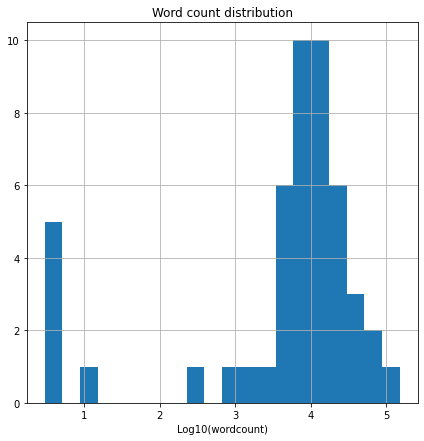

In [275]:
# Lets see how the wordcount is distributed.

websites_df['wordcount'].apply(np.log10).hist(bins = 20, figsize=(7,7))
plt.title('Word count distribution')
plt.xlabel('Log10(wordcount)')
plt.show()

In [276]:
# Viewing the 10 websites with the lowest wordcounts.

websites_df.sort_values('wordcount').head(10)

,site,raw_text,wordcount
2,de.chinaomen.com,503 Service Unavailable,3
29,www.irizar-sat.com.br,[ IRIZAR ]\nLoading...,4
3,de.foam-silicone.com,403 Forbidden\n403 Forbidden\nnginx/1.19.2,5
7,de.rilsonindustry.com,403 Forbidden\n403 Forbidden\nnginx/1.19.2,5
8,de.techoseal.com,403 Forbidden\n403 Forbidden\nnginx/1.19.2,5
37,www.miprcorp.com,403 Forbidden\nForbidden\nYou don't have permi...,13
13,poolcorp.info,Главная | Оборудование для бассейнов от мировы...,301
36,www.minipack.us,Minipack America - Chamber Vacuum Sealers & HA...,1037
26,www.hufschmied.net,Hufschmied Zerspanungssysteme GmbH\njobs\nFirm...,1396
41,www.schreiber-berlin.de,Home - Schreiber Farb- und Antikglas\nHome\nKa...,2036


From the table above we see that there are a few websites with very few words, and that they correspond mostly to failures in getting the content of the page. We should get rid of these sites, and a good way is to drop those with a low wordcount.

In [277]:
# Set minimun amount of word required to remain in the data set. 
MIN_WORDS = 100

# Drop sites with less words than MIN_WORDS.
websites_df.drop(websites_df[ websites_df['wordcount'] < MIN_WORDS ].index, inplace=True)

In [278]:
# Let's see what we have left.

websites_df.shape

(42, 3)

In [279]:
# Viewing the 10 websites with the lowest wordcounts after drop.

websites_df.sort_values('wordcount').head(10)

,site,raw_text,wordcount
13,poolcorp.info,Главная | Оборудование для бассейнов от мировы...,301
36,www.minipack.us,Minipack America - Chamber Vacuum Sealers & HA...,1037
26,www.hufschmied.net,Hufschmied Zerspanungssysteme GmbH\njobs\nFirm...,1396
41,www.schreiber-berlin.de,Home - Schreiber Farb- und Antikglas\nHome\nKa...,2036
40,www.sandprofile.de,Start - Sandprofile // DE\nEN\nDE\nSuchbegriff...,4015
19,www.besseges-vtf.co.uk,Pipe Supplier | Pipeline Products | Steel Pipe...,4102
18,www.atio.cz,"ATIO, s.r.o. - dodavatel tlakoměrů, teploměrů,...",4104
34,www.miac.com.br,Miac - Máquinas Agrícolas para Colheita Mecani...,5247
22,www.criscarreira.com,Representaciones Maquinaria Hostelería | CRIS ...,5648
12,mikro-technik.com,Mikro-Technik GmbH > Start / Haferfasern Weize...,5821


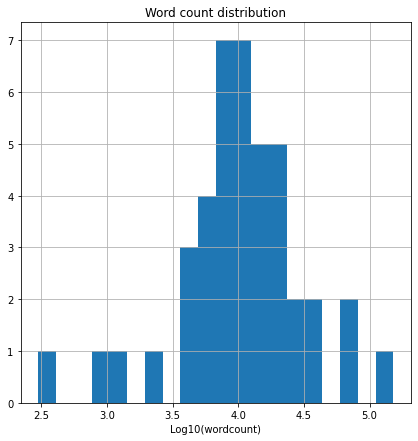

In [280]:
# Lets see how the wordcount is distributed.

websites_df['wordcount'].apply(np.log10).hist(bins = 20, figsize=(7,7))
plt.title('Word count distribution')
plt.xlabel('Log10(wordcount)')
plt.show()

We still have very different lenghts, but even a few hundred words could help us classify a site. 

Before tokenizing and vectorizing, it would be good some things that are likely to appear many times but not give us a lot of information. Since we are dealing with different languages, some language-specific pre-processing techiniques like removing stopwords or lematization would be harder to implement. 

Some things that can appear in the websites and won't give much info. 
* Pure numbers.
* Pure symbols like +, - ?, &, etc. (Beware of not removing non-latin alphabet's characters. )
* email adresses and URLs. 

The idea behind removing these elements is the intuition that sites will be clustered by language first, and then perhaps by topic within each language. The information relative to these elemenets most likely doesn't depend on the above elements. 

If I assume I know at least what some of the languages are, I can remove some of the stopwords. But this assumes knowledge that I'm not sure I have available. I will leave this aside for the time being, but it could be dealt with on a future version of the process.  

## Vectorizing text with Tf-Idf

I will use Tf-Idf to vectorize my texts. This will build a vocabulary, and assing a vector to each document. The i-th coordinate of the vector is the product between the Term Frequency and the Inverse Document Frecuency of the i-th word in the vocabulary.

Furthermore, this vectorizer will normalize all vectors to length 1, which will reduce the efect of comparing texts of very different lengths. 

In [311]:
# Creating a vectorizer object. We can pass parameter to control certain aspects
# of the vectorization process. For now we use the default values. 

vectorizer = TfidfVectorizer(stop_words=stop_words)

In [313]:
""" The default regexp select tokens of 2 or more alphanumeric characters 
(punctuation is completely ignored and always treated as a token separator)."""

' The default regexp select tokens of 2 or more alphanumeric characters \n(punctuation is completely ignored and always treated as a token separator).'

In [314]:
# Building vocabulary and vectors

doc_vectors = vectorizer.fit_transform(websites_df['raw_text'])

print(f'We obtained a vocabulary of {len(vectorizer.vocabulary_)} different words.')

We obtained a vocabulary of 89671 different words.


In [315]:
vectorizer.vocabulary_

{'gummi': 32492,
 'götz': 32759,
 'hersteller': 33757,
 'gummiformteilen': 32515,
 'dichtungen': 22939,
 'freitag': 29529,
 '22': 3034,
 'januar': 37865,
 '2021': 2840,
 'impressum': 35972,
 'agb': 12820,
 'datenschutzerklärung': 22068,
 'home': 34319,
 'produkte': 53232,
 'back': 15743,
 'gummiformartikel': 32513,
 'fenster': 28387,
 'türdichtungen': 65302,
 'profile': 53321,
 'flachdichtungen': 28837,
 'schaumstoffe': 59016,
 'dicht': 22895,
 'klebstoffe': 40166,
 'metall': 45186,
 'verbindungen': 67832,
 'schläuche': 59088,
 'gummirollen': 32534,
 'kunststoffe': 40994,
 'materialien': 44690,
 'kontakt': 40553,
 'profilen': 53324,
 'teilen': 63419,
 'individuallösungen': 36185,
 'maßanfertigungen': 44765,
 'individuell': 36187,
 'abgestimmter': 12092,
 'fertigung': 28427,
 'hochwertiger': 34253,
 'herzlich': 33779,
 'willkommen': 70746,
 'spezialist': 60957,
 'industrielle': 36228,
 'gummiformteile': 32514,
 'art': 14375,
 'seit': 59471,
 '2004': 2785,
 'schätzen': 59276,
 'kunden': 

In [287]:
vectorizer.stop_words_

{'10', '100', '12', '16', '20', '30', '50', '60'}

The vectors obtained in this way are stored in a sparse matrix (i.e. it's entries are mostly 0).

Each row corresponds to a document, and each column to a word in the vocabulary.

In [288]:
print(f'The dimensions of the document matrix are {doc_vectors.shape} .')

The dimensions of the document matrix are (42, 89663) .


###  Visualizing the document vectors

With the documents matrix built, we can explore it superficially in order to get an idea of the structures of our documents. 

We show two visualizations: The non-zero elements of the matrix, and the cosine similarity matrix. 

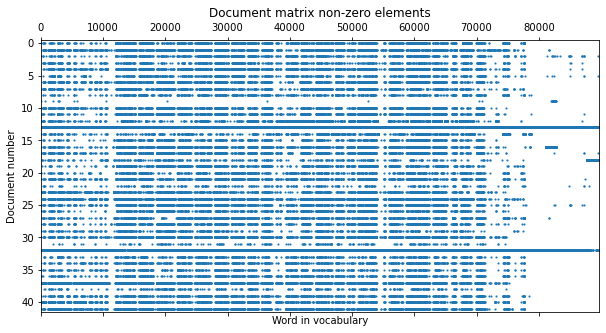

In [289]:
# Visualizing the non-zero elements of the matrix. 

plt.figure(figsize=(10, 5))
plt.spy(doc_vectors, markersize=1, aspect = 'auto')
plt.title('Document matrix non-zero elements')
plt.xlabel('Word in vocabulary')
plt.ylabel('Document number')
plt.show()

From this plot we can see there are two documents (numbers 13 and 32) containtn a lot of words (they look like horizontal lines) and one (number 9) with very few. The rest of them seem mostly balanced, but in any case shouldn't be a major factor. 

From this bird's eye view of our data we cannont distinguish any clear cluster structure.
This may seem suprising, as one might expect that at least sites would naturally be clustered by language. However, words in the vocabulary are not grouped by language, hiding this effect. 

In [290]:
# Computing cosine similarities. Since verctors are normalized to 1, 
# it suffices to multiply the matrix by its transpose. 

cosine_sims = doc_vectors * doc_vectors.transpose()

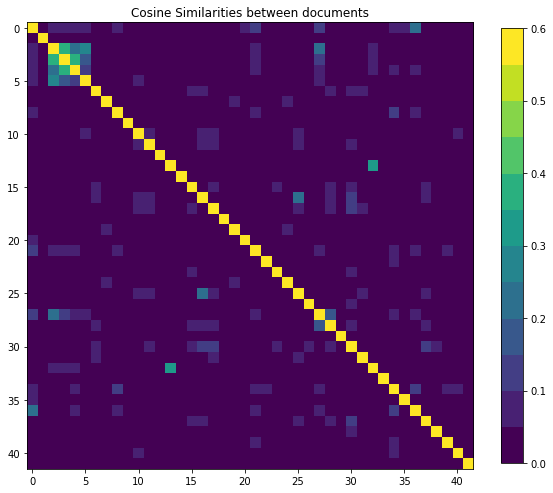

In [291]:
# Heatmap of the cosine similarities. 
# There are no correletions higher than 0.6 (other than the diagonal), 
# So we choose this value for a cutoff of the scale.

my_cmap = cm.get_cmap('viridis', 12)
plt.figure(figsize=(10,10))
plt.imshow(cosine_sims.toarray(), cmap=my_cmap, vmax=0.6)
plt.colorbar(shrink = 0.8)

plt.title('Cosine Similarities between documents')

plt.show()

##  Clustering using KMeans

In [292]:
# Create a model

KMeans_model = KMeans(n_clusters = 5, n_init=20, max_iter= 500 )

In [293]:
# Find the clusters
KMeans_model.fit(doc_vectors)

KMeans(max_iter=500, n_clusters=5, n_init=20)

In [294]:
# Write the labels into the dataframe.
websites_df['cluster_label'] =  KMeans_model.labels_

In [295]:
# How many elements in each cluster?
websites_df.groupby('cluster_label')['site'].count()

cluster_label
0     5
1     7
2    15
3     9
4     6
Name: site, dtype: int64

In [296]:
# Let's see cosine simlarities ordered by cluster

sorted_vecs = vectorizer.transform(websites_df.sort_values('cluster_label')['raw_text'])


In [297]:
ordered_indices = websites_df.sort_values('cluster_label')['cluster_label']
clabel = np.zeros((42, 42), dtype = int)

In [298]:
for i in range(42):
    for j in range(42):
        if ordered_indices.iloc[i] == ordered_indices.iloc[j]:
            clabel[i,j] = ordered_indices.iloc[i]+1
            
clabel

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5],
       [0, 0, 0, ..., 5, 5, 5]])

In [299]:
#get stopwords for many languages

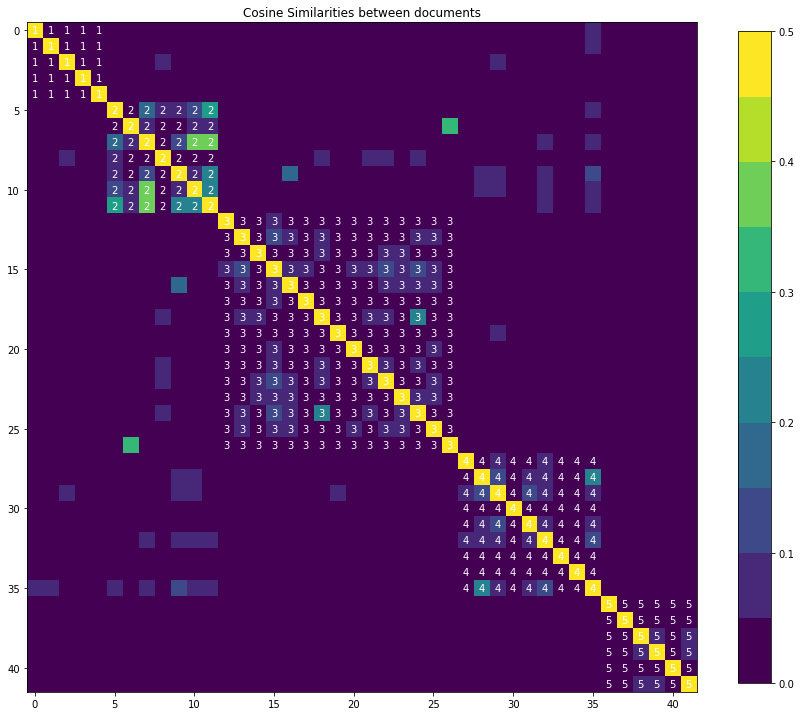

In [300]:
# Sorted cosine sims
sorted_sims = sorted_vecs * sorted_vecs.transpose()

my_cmap = cm.get_cmap('viridis', 10)
plt.figure(figsize=(15,15))
plt.imshow(sorted_sims.toarray(), cmap=my_cmap, vmax=0.5)
plt.colorbar(shrink = 0.8)

for i in range(42):
    for j in range(42):
        if clabel[i, j] !=0:
            text = plt.text(j, i, clabel[i, j],
                           ha="center", va="center", color="w")

plt.title('Cosine Similarities between documents')

plt.show()


In [307]:
websites_df[websites_df['cluster_label']==4]

,site,raw_text,wordcount,cluster_label
1,barrocorestaurante.mx,Equipo de minería máquina zg pantalla vibrator...,22699,4
11,lumaquin.com,"Lumaquin, SA. Equipos para el control de calid...",10557,4
22,www.criscarreira.com,Representaciones Maquinaria Hostelería | CRIS ...,5648,4
23,www.gre.es,Gre - Piscinas - Pool - Piscine - Schwimmbecke...,8666,4
28,www.ictsl.net,"ICT, SL - Material de laboratorio\nVersión de ...",63700,4
34,www.miac.com.br,Miac - Máquinas Agrícolas para Colheita Mecani...,5247,4


In [302]:
cluster_dict = {}
for i in range(KMeans_model.cluster_centers_.shape[0]):
    vec = KMeans_model.cluster_centers_[i]
    argsorted = np.argsort(vec)[::-1]
    
    cluster_dict[f'{i}'] = [temp[i] for i in argsorted[:15]]

In [310]:
for k, v in cluster_dict.items():
    print(f'Cluster {k} most important words \n')
    print(' '.join(v))
    print('\n\n'+'='*20 )

Cluster 0 most important words 

jf¾ kaz xkoogsypvldr 00 sustancias disuelto bereichen αγαθών πx s2n z1g ante 499 auditors 962


Cluster 1 most important words 

prinstner dfpd são portland bjb ai_adult v3q7 506 glasmalereien pí erfassung aepd dfl portacuchillas arruados


Cluster 2 most important words 

keuze portacandados t❻ reactores adhesiva ud7 bolsas conservadores handhabung jܘ molino kʔ storia ah7e hogere


Cluster 3 most important words 

afgifte greift handwaschbürtse portland was孀 klebens gj3 hauseinführungskombinationen aiheuttama sӟj igr ráòšr ag astrid melko


Cluster 4 most important words 

cnp6 lm4 gnw discharge agilidade peas hnñí vdt hkws mediar portable m2vn farmaceuticos circunstancias 수신기의


